### Cosc2671 Assignment 2 Group 15 


In [4]:
import pandas as pd
import numpy as np
import praw
import matplotlib.pyplot as plt

   Hours_Studied  Exam_Score
0              1          50
1              2          55
2              3          60
3              4          65
4              5          70
5              6          75
6              7          80
7              8          85


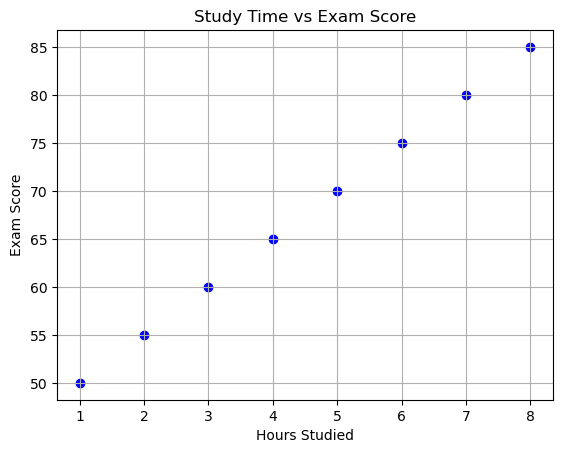

In [5]:
data = {
    'Hours_Studied': [1, 2, 3, 4, 5, 6, 7, 8],
    'Exam_Score': [50, 55, 60, 65, 70, 75, 80, 85]
}

df = pd.DataFrame(data)

# Step 2: Display the DataFrame
print(df)

# Step 3: Create a scatter plot
plt.scatter(df['Hours_Studied'], df['Exam_Score'], color='blue', marker='o')
plt.title('Study Time vs Exam Score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.grid(True)
plt.show()